# GoEmotions Context 2 Evaluation

In [ ]:
from transformers import (
    AutoTokenizer,
    BertForSequenceClassification,
    TrainingArguments,
    Trainer,
)
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from ast import literal_eval
from collections import Counter
from scipy.stats import entropy
import re

In [ ]:
sns.set(rc={'figure.figsize':(12, 8)})

## Data

In [ ]:
!wget https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/emotions.txt

## Preparations

In [ ]:
labels_df = pd.read_csv('emotions.txt', header=None)
ID_TO_EMOTION = dict(labels_df[0])
EMOTION_TO_ID = {emotion: emotion_id for emotion_id, emotion in ID_TO_EMOTION.items()}

In [ ]:
#GPT_EVALUTION_FILE_PATH = "datasets/Ewaluacja ChatGPT - zadania - GoEmotion Personalized With Context 2.csv"

In [ ]:
#gpt_evaluation_df = pd.read_csv(GPT_EVALUTION_FILE_PATH)
gpt_evaluation_df = pd.read_excel('ChatGPT Evaluation v2.0.xlsx', sheet_name='14.GoEmoPer0')

## Statystyki

In [ ]:
gpt_evaluation_df["annotation"] = gpt_evaluation_df["annotation"].apply(literal_eval)
counter = Counter(
    gpt_evaluation_df["annotation"].sum()
)
print(max(counter.values()), min(counter.values()))
print(entropy(list(counter.values())))

288 6
2.982637337506349


## Preprocessing

### # Cases required manual correction)

In [ ]:
len(gpt_evaluation_df.query("chatgpt_final != chatgpt_raw"))

0

### Correct invalid response format

In [ ]:
for idx, evaluation in enumerate(gpt_evaluation_df["chatgpt_final"]):
    try:
        literal_eval(evaluation)
    except Exception:
        print(idx, evaluation)

In [ ]:
gpt_evaluation_df.loc[846, "chatgpt_final"] = '["neutral"]'
gpt_evaluation_df.loc[940, "chatgpt_final"] = '["disapproval"]'

In [ ]:
gpt_evaluation_df["chatgpt_final"] = gpt_evaluation_df["chatgpt_final"].apply(literal_eval)

### Filet our cases where GPT gave no answer

In [ ]:
print(len(gpt_evaluation_df))
gpt_evaluation_df = gpt_evaluation_df.dropna(subset=["chatgpt_final"])
print(len(gpt_evaluation_df))

1151
1151


### Filter out cases where GPT gave invalid answer
* In cases where GPT gave invalid answer (e.g. label with spelling mistake) we need to filter them out)

In [ ]:
unique_gpt_answers = set()
for evaluation in gpt_evaluation_df["chatgpt_final"]:
    unique_gpt_answers = unique_gpt_answers.union(set(evaluation))

In [ ]:
len(unique_gpt_answers)

35

In [ ]:
is_valid_label_map = {
    label: label in EMOTION_TO_ID
    for label in unique_gpt_answers
}

In [ ]:
print(len(gpt_evaluation_df))
gpt_evaluation_df = gpt_evaluation_df.loc[
    gpt_evaluation_df["chatgpt_final"].apply(
        lambda labels: all((is_valid_label_map[label] for label in labels))
    )
]
print(len(gpt_evaluation_df))

1151
1143


## Encode model predictions

In [ ]:
def encode_one_hot(annotations: list[str], dtype: str = "bool"):
    one_hot = np.zeros(len(ID_TO_EMOTION), dtype=dtype)
    for emotion in annotations:
        one_hot[EMOTION_TO_ID[emotion]] = 1
    return one_hot

gpt_evaluation_df["true_labels"] =  gpt_evaluation_df["annotation"].apply(
    encode_one_hot
)

In [ ]:
gpt_evaluation_df["gpt_labels"] =  gpt_evaluation_df["chatgpt_final"].apply(encode_one_hot)

## Obtain model predictions

### Load pretrained model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("monologg/bert-base-cased-goemotions-original")
model = BertForSequenceClassification.from_pretrained("monologg/bert-base-cased-goemotions-original")

### Add annotator ID as special tokens

In [ ]:
special_tokens_map = {
    "additional_special_tokens": []
}
for rater_id in gpt_evaluation_df["rater_id"].unique():
    special_tokens_map["additional_special_tokens"].append(f"<{rater_id}>")
tokenizer.add_special_tokens(special_tokens_map)

81

In [ ]:
model.resize_token_embeddings(len(tokenizer))

Embedding(29077, 768)

In [ ]:
def create_personalized_text(annotator_id: int, text: str) -> str:
    return f"<{annotator_id}> {text}"

In [ ]:
gpt_evaluation_df["text_with_special_tokens"] = gpt_evaluation_df.apply(
    lambda row: create_personalized_text(row.rater_id, row.text),
    axis=1,
)

In [ ]:
gpt_evaluation_df["text_with_special_tokens"].head(2)

0    <0> That’s how I outfitted my team in that awe...
1        <0> All I want for Christmas is a broken home
Name: text_with_special_tokens, dtype: object

### Finetune model
#### Build train data

In [ ]:
pattern = re.compile(r"Known text: (?P<text>.+); Emotions?: (?P<emotion>[\w, ]*)\.?\n")

In [ ]:
text_annotations_pairs = []
train_annotator_ids = []
for prompt, annotator_id in zip(gpt_evaluation_df["prompt"], gpt_evaluation_df["rater_id"]):
    match = pattern.findall(prompt)
    text_annotations_pairs.extend(match)
    for _ in match:
        train_annotator_ids.append(annotator_id)

In [ ]:
assert 2 * len(gpt_evaluation_df["prompt"]) == len(text_annotations_pairs)

In [ ]:
text_annotations_pairs = [
    (text, annotations_txt.split(", ") if len(annotations_txt) > 1 else [])
    for text, annotations_txt
    in text_annotations_pairs
]

In [ ]:
train_texts, train_annotations = list(zip(*text_annotations_pairs))

In [ ]:
train_texts_with_special_token = [
    create_personalized_text(annotator_id, text)
    for annotator_id, text
    in zip(train_annotator_ids, train_texts)
]

In [ ]:
train_encoddings = tokenizer(
    train_texts_with_special_token,
    return_tensors="pt",
    truncation=True,
    padding="max_length",
)

In [ ]:
train_true_labels = [
    encode_one_hot(annotations, dtype="float")
    for annotations in train_annotations
]

#### Training

In [ ]:
class GoEmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    y_pred = torch.from_numpy(y_pred)
    y_true = torch.from_numpy(y_true)
    y_pred = y_pred.sigmoid()
    accuracy = ((y_pred>thresh)==y_true.bool()).float().mean().item()
    return {'accuracy': accuracy}

In [ ]:
train_ds = GoEmotionDataset(
    encodings=train_encoddings,
    labels=train_true_labels,
)

In [ ]:
batch_size = 4
# configure logging so we see training loss
logging_steps = len(train_ds) // batch_size

args = TrainingArguments(
    output_dir="emotion",
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_steps=logging_steps,
)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

/home/cicheck/.pyenv/versions/3.10.2/envs/affective/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2286
  Num Epochs = 5
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 2860
  Number of trainable parameters = 108394012
/tmp/ipykernel_62497/1483352751.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
You're using a BertTokenizerFast tokenizer. 

Step,Training Loss
571,0.119400
1142,0.073400
1713,0.047700
2284,0.033300
2855,0.024000


Saving model checkpoint to emotion/checkpoint-572
Configuration saved in emotion/checkpoint-572/config.json
Model weights saved in emotion/checkpoint-572/pytorch_model.bin
tokenizer config file saved in emotion/checkpoint-572/tokenizer_config.json
Special tokens file saved in emotion/checkpoint-572/special_tokens_map.json
/tmp/ipykernel_62497/1483352751.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Saving model checkpoint to emotion/checkpoint-1144
Configuration saved in emotion/checkpoint-1144/config.json
Model weights saved in emotion/checkpoint-1144/pytorch_model.bin
tokenizer config file saved in emotion/checkpoint-1144/tokenizer_config.json
Special tokens file saved in emotion/checkpoint-1144/special_tokens_map.json
/tmp/ipykernel_62497/1483352751.py:

TrainOutput(global_step=2860, training_loss=0.059517675179701586, metrics={'train_runtime': 922.5956, 'train_samples_per_second': 12.389, 'train_steps_per_second': 3.1, 'total_flos': 3008061411287040.0, 'train_loss': 0.059517675179701586, 'epoch': 5.0})

### Get model predictions

In [ ]:
def get_model_predictions(text: str) -> np.ndarray:
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
    )
    inputs = {key: value.cuda() for key, value in inputs.items()}
    logits = model(**inputs).logits
    return (torch.sigmoid(logits.cpu()).squeeze(dim=0) > 0.5).numpy()

In [ ]:
gpt_evaluation_df["sota_labels"] = gpt_evaluation_df["text_with_special_tokens"].apply(
    get_model_predictions
)

## Evaluation

### SOTA

In [ ]:
accuracy_score(
    y_true=np.array(gpt_evaluation_df["true_labels"].tolist()),
    y_pred=np.array(gpt_evaluation_df["sota_labels"].tolist()),
)

0.2904636920384952

In [ ]:
f1_score(
    y_true=np.array(gpt_evaluation_df["true_labels"].tolist()),
    y_pred=np.array(gpt_evaluation_df["sota_labels"].tolist()),
    average='macro',
)

0.3031394000545273

### GPT

In [ ]:
accuracy_score(
    y_true=np.array(gpt_evaluation_df["true_labels"].tolist()),
    y_pred=np.array(gpt_evaluation_df["gpt_labels"].tolist()),
)

0.22659667541557305

In [ ]:
f1_score(
    y_true=np.array(gpt_evaluation_df["true_labels"].tolist()),
    y_pred=np.array(gpt_evaluation_df["gpt_labels"].tolist()),
    average='macro',
)

0.20336795408275135

## Per class metrics

In [ ]:
metrics = []
for emotion, emotion_id in EMOTION_TO_ID.items():
    true_labels = gpt_evaluation_df["true_labels"].apply(lambda labels: labels[emotion_id]).values
    sota_labels = gpt_evaluation_df["sota_labels"].apply(lambda labels: labels[emotion_id]).values
    gpt_labels = gpt_evaluation_df["gpt_labels"].apply(lambda labels: labels[emotion_id]).values
    metrics.append(
        {
            "Emotion": emotion,
            "Emotion ID": emotion_id,
            "Accuracy": accuracy_score(
                y_true=true_labels,
                y_pred=sota_labels,
            ),
            "F1Score": f1_score(
                y_true=true_labels,
                y_pred=sota_labels,
            ),
            "Model": "SOTA",
        }
    )
    metrics.append(
        {
            "Emotion": emotion,
            "Emotion ID": emotion_id,
            "Accuracy": accuracy_score(
                y_true=true_labels,
                y_pred=gpt_labels,
            ),
            "F1Score": f1_score(
                y_true=true_labels,
                y_pred=gpt_labels,
            ),
            "Model": "GPT",
        }
    )
metrics_df = pd.DataFrame(metrics)

In [ ]:
metrics_df[metrics_df["Model"] == "GPT"]["F1Score"].tolist()

[0.24793388429752067,
 0.32222222222222224,
 0.3076923076923077,
 0.2091503267973856,
 0.11678832116788321,
 0.1739130434782609,
 0.11999999999999998,
 0.3008849557522123,
 0.13793103448275862,
 0.2773722627737226,
 0.2091503267973856,
 0.24999999999999994,
 0.1,
 0.10714285714285714,
 0.19047619047619047,
 0.36363636363636365,
 0.25,
 0.0,
 0.23728813559322035,
 0.25,
 0.18918918918918917,
 0.23529411764705882,
 0.11111111111111112,
 0.0,
 0.11764705882352942,
 0.3943661971830986,
 0.09302325581395347,
 0.382089552238806]

In [ ]:
metrics_df[metrics_df["Model"] == "SOTA"]["F1Score"].tolist()

[0.48484848484848486,
 0.7184466019417476,
 0.37209302325581395,
 0.225,
 0.19999999999999998,
 0.27692307692307694,
 0.39999999999999997,
 0.31111111111111106,
 0.20689655172413793,
 0.1348314606741573,
 0.2476190476190476,
 0.24999999999999994,
 0.23076923076923078,
 0.20408163265306123,
 0.35714285714285715,
 0.7769784172661871,
 0.0,
 0.3125,
 0.7045454545454546,
 0.0,
 0.25,
 0.0,
 0.15151515151515152,
 0.0,
 0.39999999999999997,
 0.4776119402985074,
 0.2857142857142857,
 0.509274873524452]

[Text(0.5, 1.0, 'SOTA scores for GoEmotions Personalized No Context')]

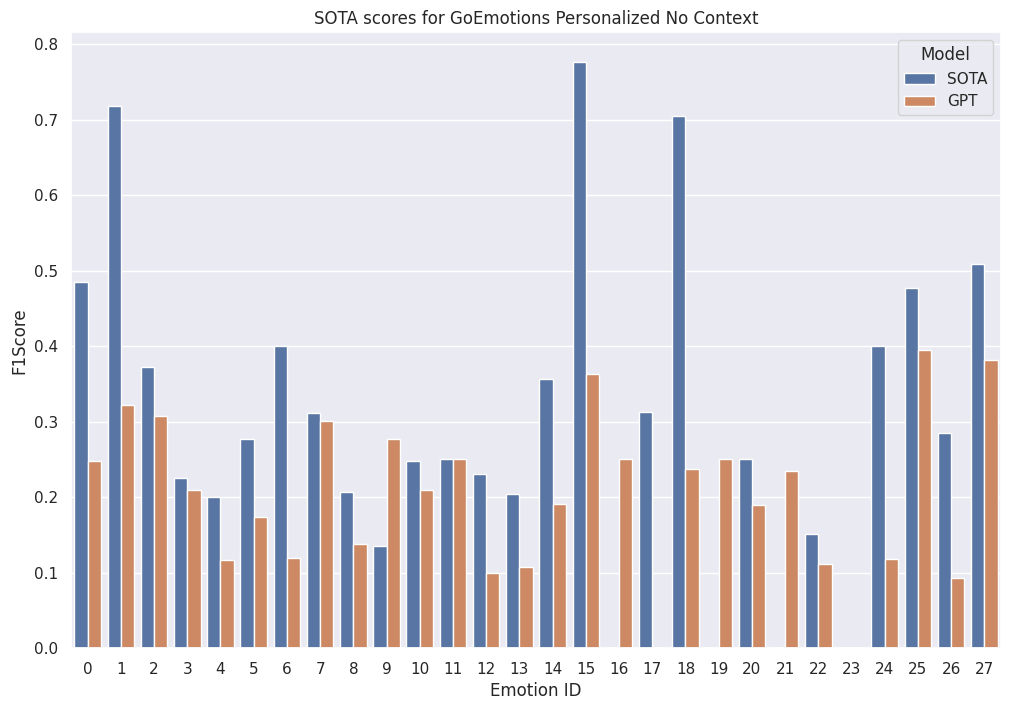

In [ ]:
fig = sns.barplot(
    data=metrics_df,
    x="Emotion ID",
    y="F1Score",
    hue="Model",
).set(title="SOTA scores for GoEmotions Personalized No Context")
#plt.xticks(rotation=45)
fig

## Biggest model mistakes

In [ ]:
gpt_evaluation_df["sota_annotation"] = gpt_evaluation_df["sota_labels"].apply(
    lambda labels: [
        ID_TO_EMOTION[idx]
        for idx, value in enumerate(labels)
        if value
    ]
)

In [ ]:
def compute_model_score(predictions, annotations) -> int:
    predictions = set(predictions)
    annotations = set(annotations)
    n_correct = len(predictions & annotations)
    n_incorrect = len(predictions ^ annotations)
    return n_correct - n_incorrect

In [ ]:
gpt_evaluation_df["gpt_score"] = gpt_evaluation_df.apply(
    lambda row: compute_model_score(row.chatgpt_final, row.annotation),
    axis=1,
)
gpt_evaluation_df["sota_score"] = gpt_evaluation_df.apply(
    lambda row: compute_model_score(row.sota_annotation, row.annotation),
    axis=1,
)
gpt_evaluation_df = gpt_evaluation_df.sort_values("gpt_score")

## Save results

In [ ]:
metrics_df.to_csv("results/goemotions/metrics/context_2.csv")
gpt_evaluation_df.to_csv("results/goemotions/data/context_2.csv", sep=";")
# Best & Worst GPT predictions
columns = ["text", "prompt", "annotation", "gpt_score", "sota_score", "chatgpt_final", "sota_labels"]
gpt_evaluation_df[columns].head(10).to_csv("results/goemotions/worst/context_2.csv", sep=";")
gpt_evaluation_df[columns].tail(10).to_csv("results/goemotions/best/context_2.csv", sep=";")